## Import Necessary Libraries and read datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
df = pd.merge(transactions, customers.drop('CustomerName', axis='columns'), on='CustomerID')
df = pd.merge(df, products.drop('Price', axis='columns'), on='ProductID')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics


### To build a customer segmentation/clustering model, we will use RFM features. RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for: Recency(R), Frequency(F), Monetary(M).

In [5]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])

### Recency(R): In this step, we focus on understanding how recently a customer has made a purchase.

In [6]:
# Convert TransactionDate to datetime and extract only the date
df['TransactionDay'] = df['TransactionDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['TransactionDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['TransactionDay'].max()

# Convert TransactionDay to datetime type before subtraction
customer_data['TransactionDay'] = pd.to_datetime(customer_data['TransactionDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['TransactionDay']).dt.days

# Remove the TransactionDay column
customer_data.drop(columns=['TransactionDay'], inplace=True)

customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,C0001,56
1,C0002,25
2,C0003,126
3,C0004,5
4,C0005,54


### Frequency(F): In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer.

In [7]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
total_transactions.rename(columns={'TransactionID': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,C0001,56,5,12
1,C0002,25,4,10
2,C0003,126,4,14
3,C0004,5,8,23
4,C0005,54,3,7


### Monetary(M): In this step, I am going to create two features that represent the monetary aspect of customer's transactions.

In [8]:
# Calculate the total spend by each customer
total_spend = df.groupby('CustomerID')['TotalValue'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['TotalValue'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value
0,C0001,56,5,12,3354.52,670.904
1,C0002,25,4,10,1862.74,465.685
2,C0003,126,4,14,2725.38,681.345
3,C0004,5,8,23,5354.88,669.360
4,C0005,54,3,7,2034.24,678.080


### Product Diversity

In [9]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['ProductID'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProductID': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,56,5,12,3354.52,670.904,5
1,C0002,25,4,10,1862.74,465.685,4
2,C0003,126,4,14,2725.38,681.345,4
3,C0004,5,8,23,5354.88,669.360,8
4,C0005,54,3,7,2034.24,678.080,3


In [10]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,56,5,12,3354.52,670.904,5
1,C0002,25,4,10,1862.74,465.685,4
2,C0003,126,4,14,2725.38,681.345,4
3,C0004,5,8,23,5354.88,669.36,8
4,C0005,54,3,7,2034.24,678.08,3
5,C0006,82,4,12,4227.57,1056.8925,4
6,C0007,125,3,8,2579.82,859.94,3
7,C0008,11,10,20,4271.61,427.161,10
8,C0009,77,3,3,896.5,298.833333,3
9,C0010,42,4,12,1717.55,429.3875,4


In [11]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 199 non-null    string 
 1   Days_Since_Last_Purchase   199 non-null    Int64  
 2   Total_Transactions         199 non-null    Int64  
 3   Total_Products_Purchased   199 non-null    Int64  
 4   TotalValue                 199 non-null    Float64
 5   Average_Transaction_Value  199 non-null    Float64
 6   Unique_Products_Purchased  199 non-null    Int64  
dtypes: Float64(2), Int64(4), string(1)
memory usage: 12.2 KB


### Correlational Analysis

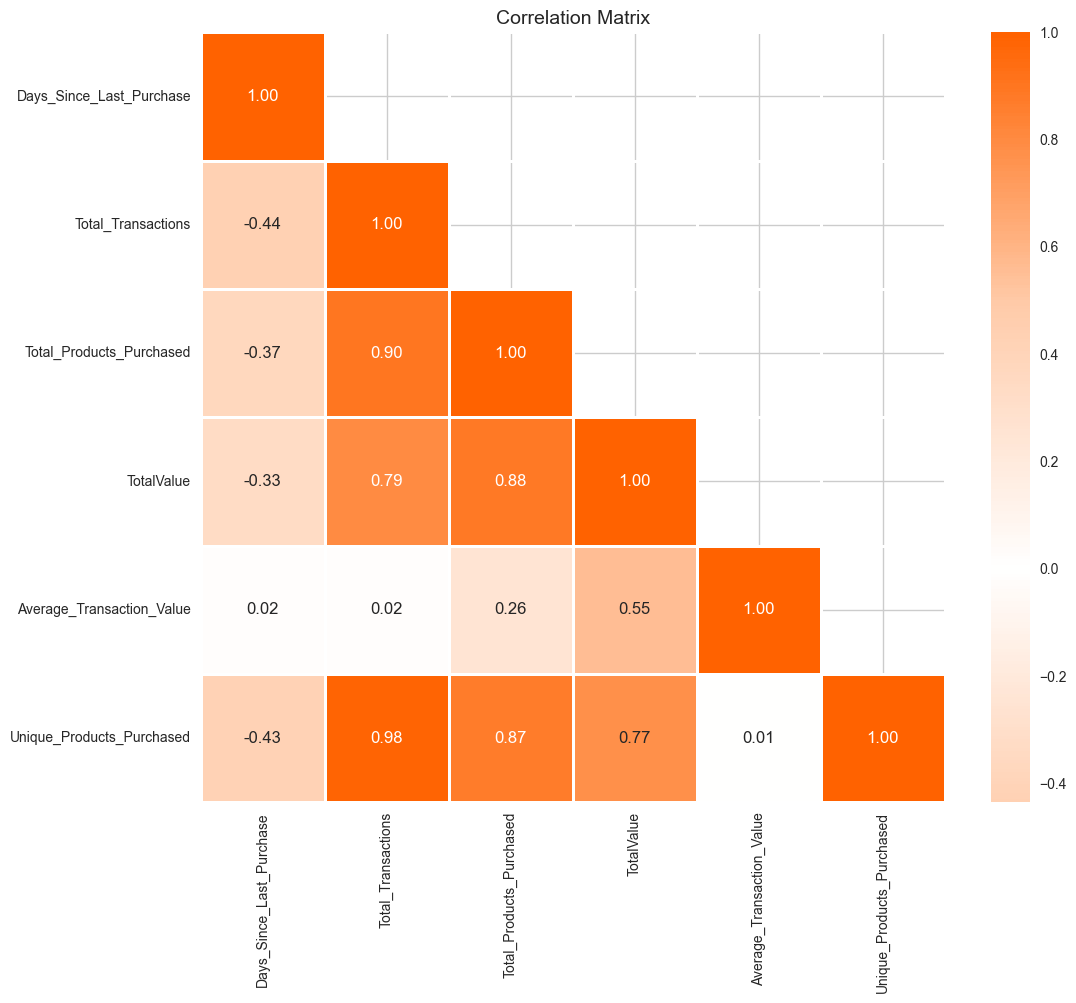

In [12]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Feature Scaling

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Region', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased
0,C0001,-0.261180,-0.011458,-0.122033,-0.061701,-0.070263,0.050047
1,C0002,-0.699369,-0.467494,-0.448000,-0.877744,-0.934933,-0.424204
2,C0003,0.728278,-0.467494,0.203934,-0.405857,-0.026271,-0.424204
3,C0004,-0.982071,1.356650,1.670787,1.032547,-0.076769,1.472798
4,C0005,-0.289450,-0.923530,-0.936951,-0.783929,-0.040028,-0.898455


### Dimensionality Reduction using PCA

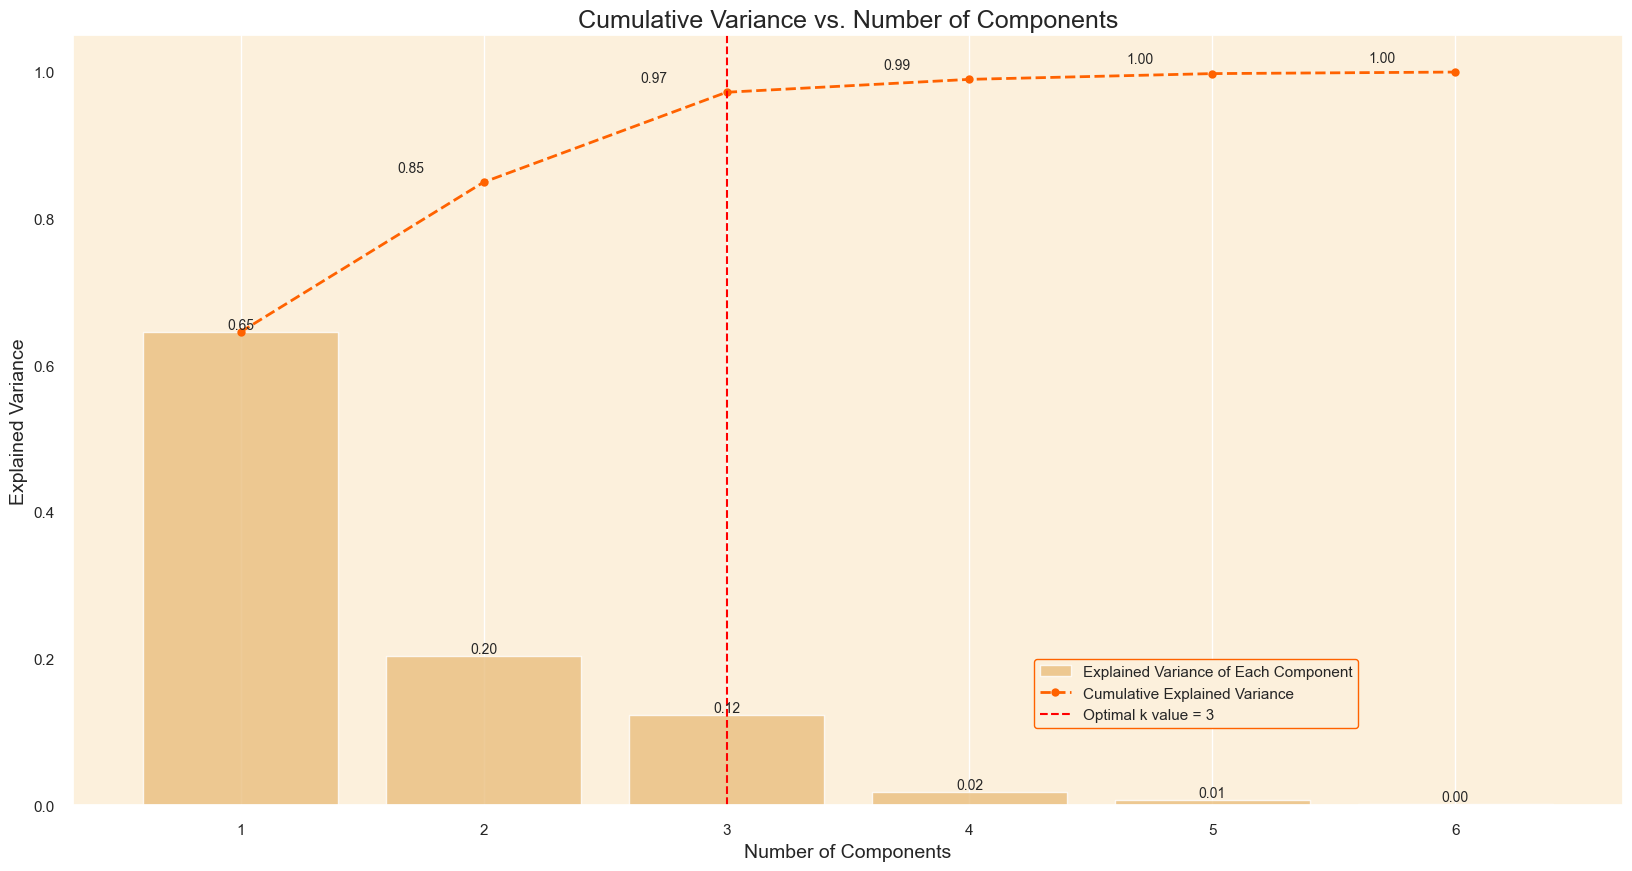

In [14]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 3)
optimal_k = 3

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [15]:
# Creating a PCA object with 3 components
pca = PCA(n_components=3)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3
CustomerID,,,
C0001,-0.011581,-0.178932,-0.228933
C0002,-1.001908,-1.129527,-0.638001
C0003,-0.711337,0.283387,0.512732
C0004,2.894169,-0.573878,-0.035399
C0005,-1.625527,-0.043407,-0.769466


### Determining the Optimal Number of Clusters: Elbow Method

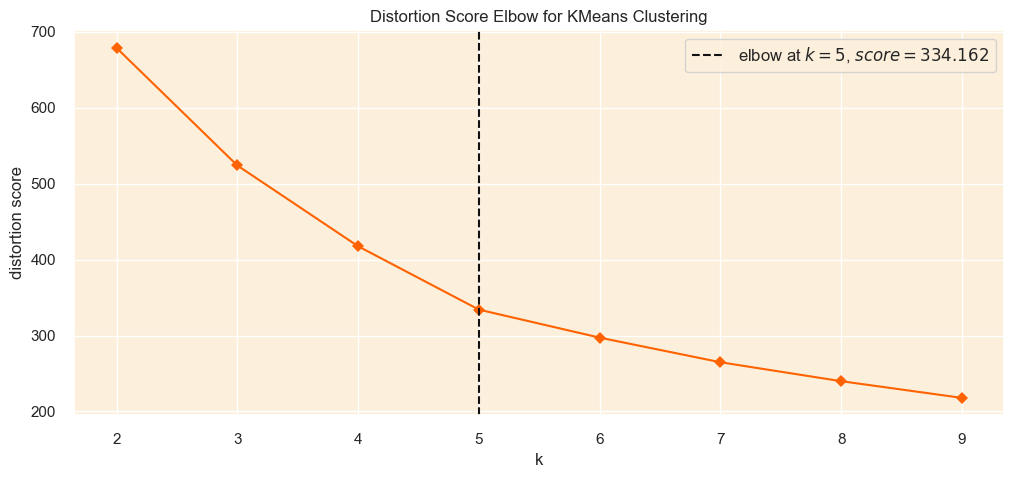

In [16]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 10), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

### Determining the Optimal Number of Clusters: Silhouette Method

In [17]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

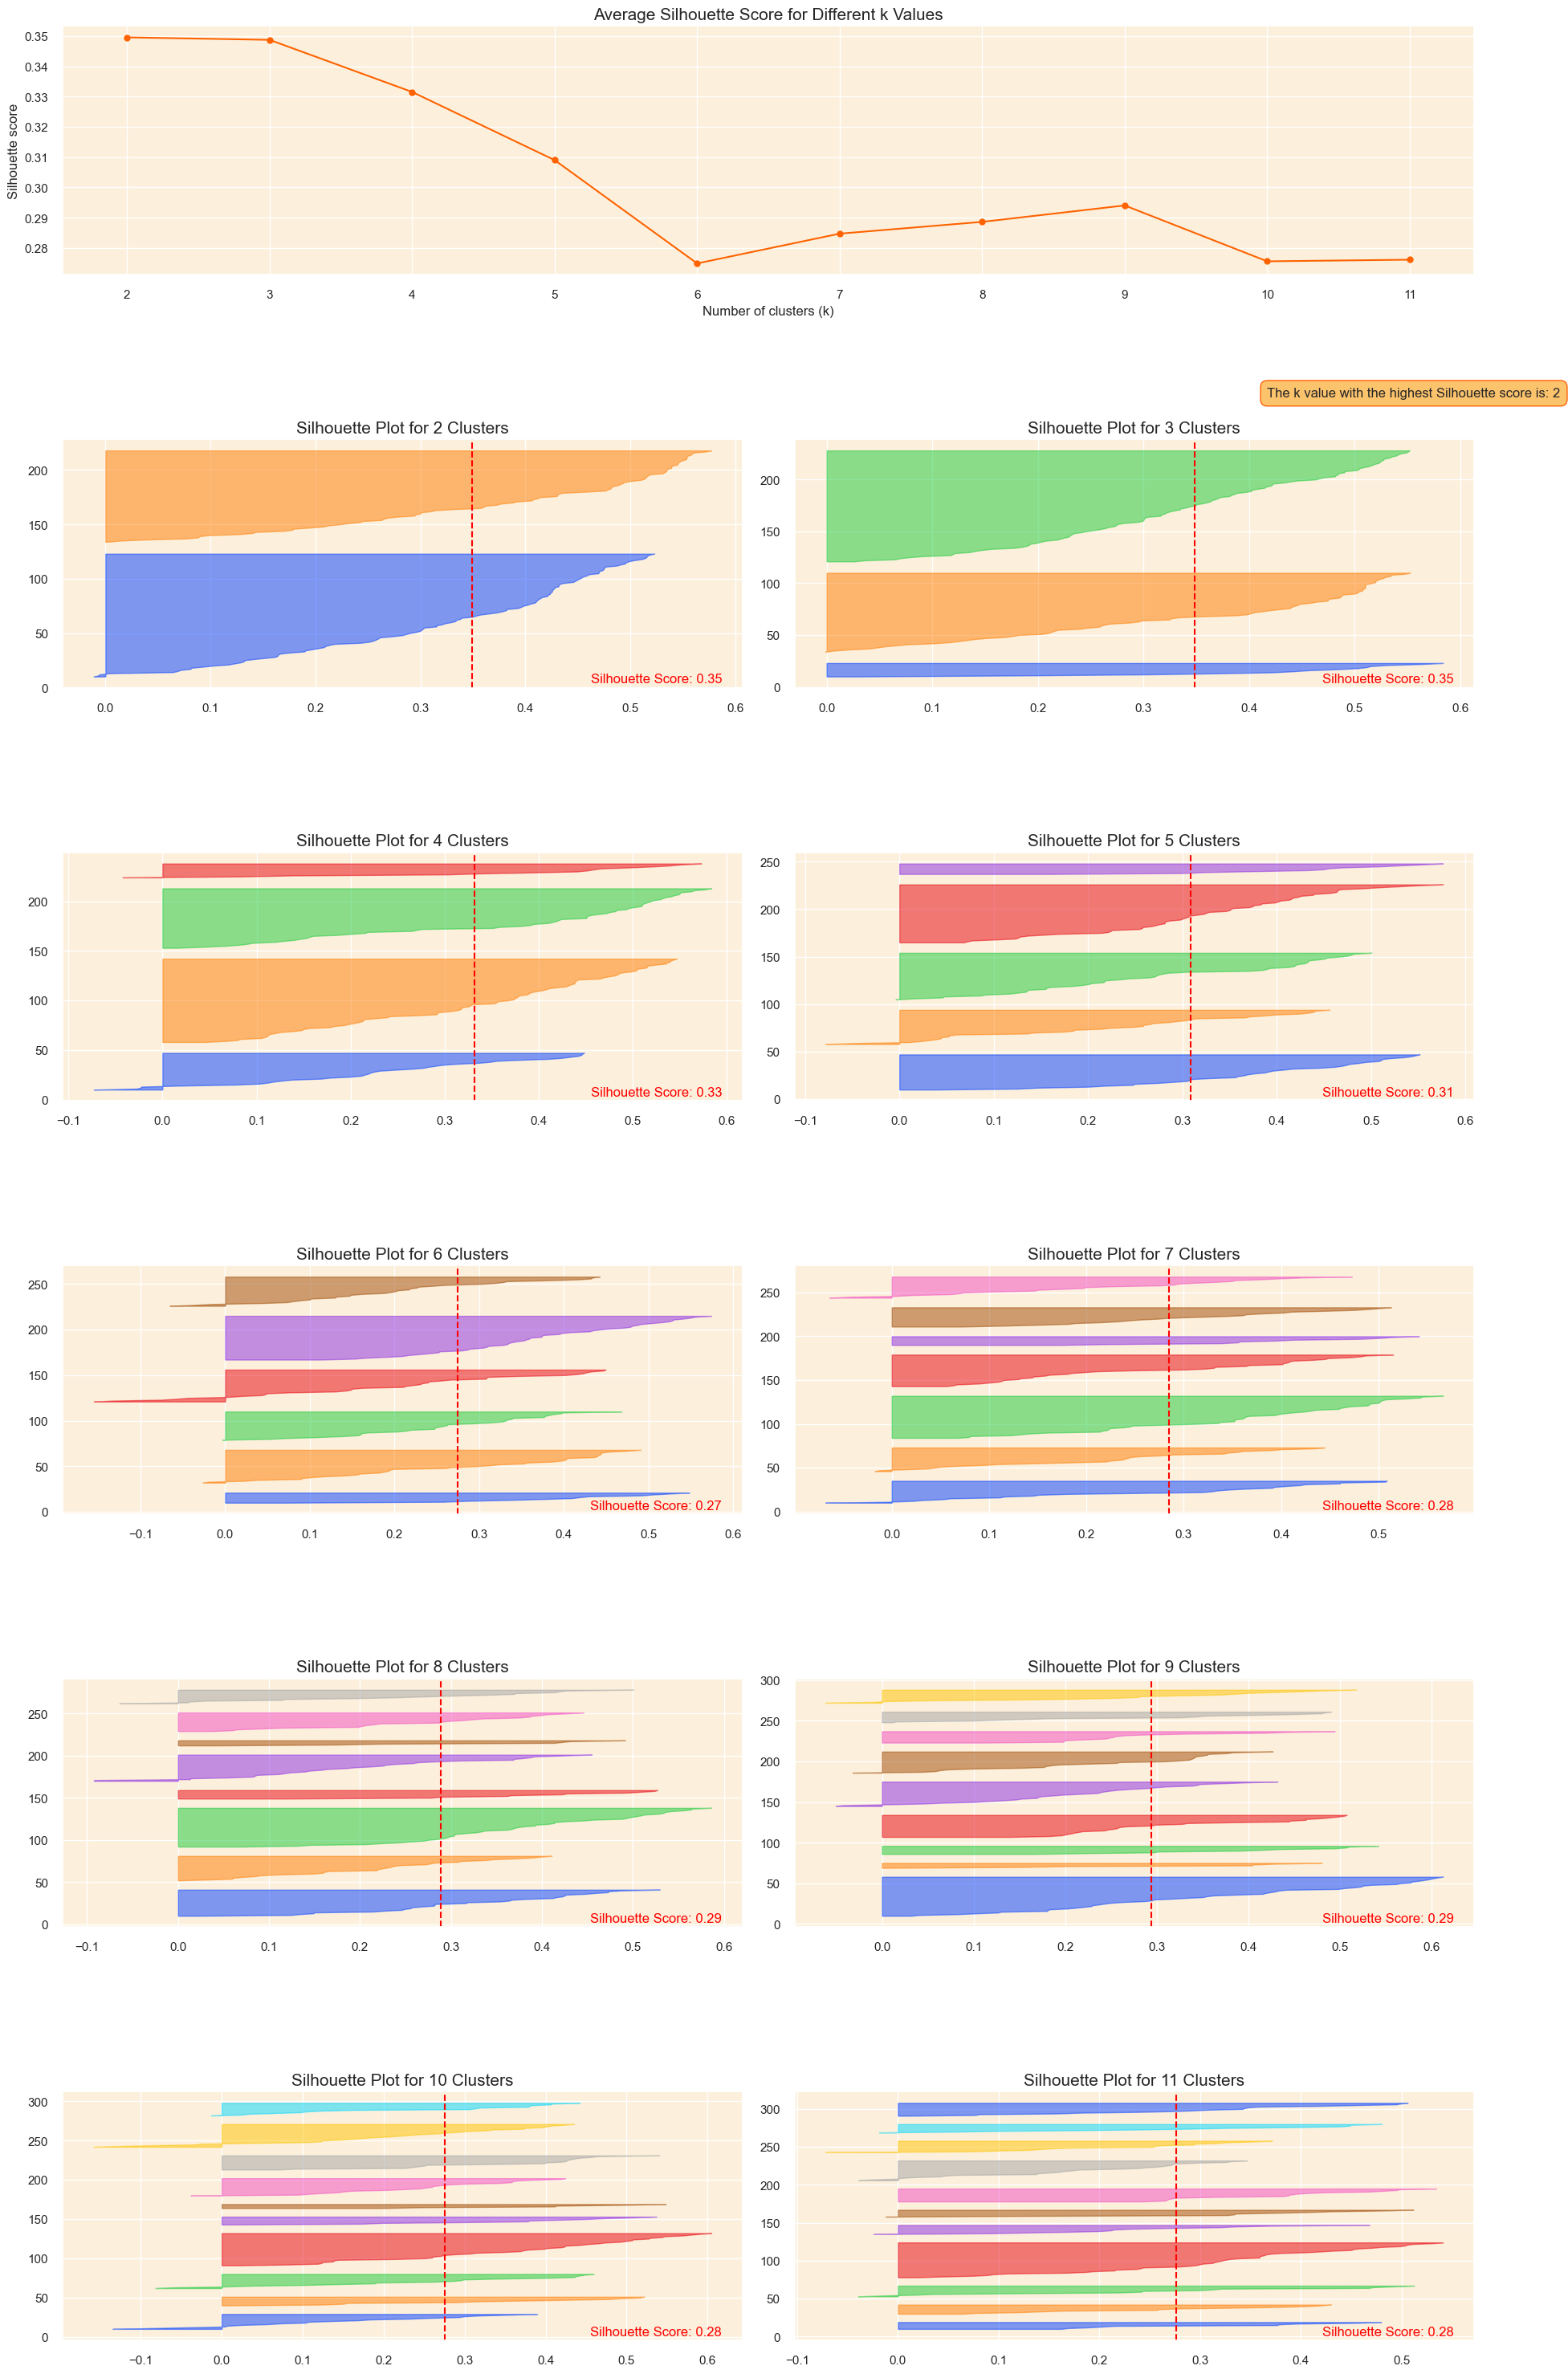

In [18]:
silhouette_analysis(customer_data_pca, 2, 11, figsize=(20, 50))

### Clustering Model - K-means

In [19]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [20]:
# Display the first few rows of the original dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalValue,Average_Transaction_Value,Unique_Products_Purchased,cluster
0,C0001,56,5,12,3354.52,670.904,5,0
1,C0002,25,4,10,1862.74,465.685,4,0
2,C0003,126,4,14,2725.38,681.345,4,0
3,C0004,5,8,23,5354.88,669.36,8,2
4,C0005,54,3,7,2034.24,678.08,3,0


### 3D Visualization

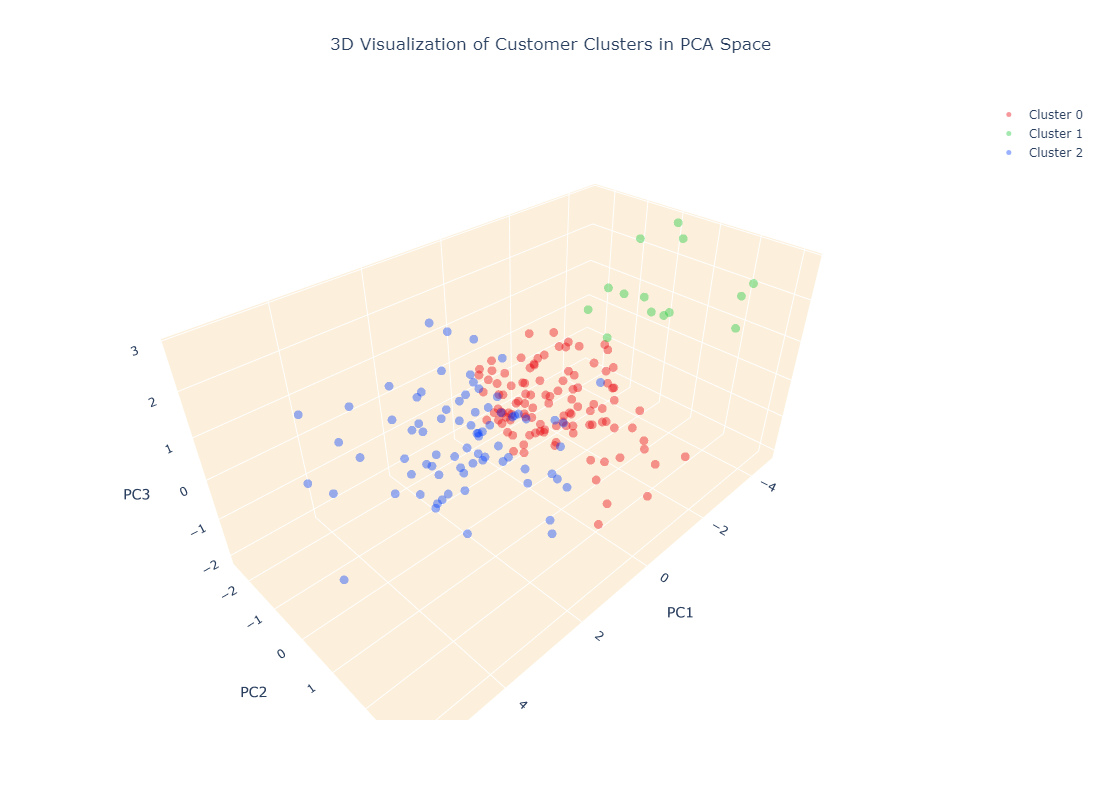

In [21]:
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

### Cluster Distribution Visualization

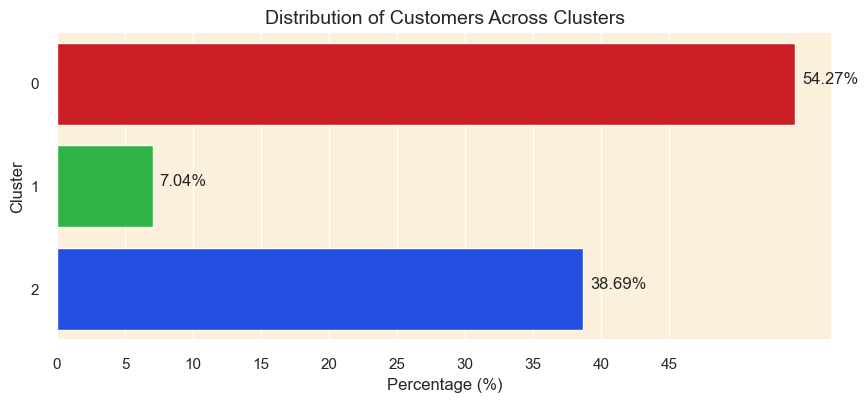

In [22]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

### Evaluation Metrics

In [23]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        199         |
|    Silhouette Score     | 0.3487527933145764 |
| Calinski Harabasz Score | 119.13682829723692 |
|  Davies Bouldin Score   | 0.9601010619506697 |
+-------------------------+--------------------+
